In [1]:
import gc
from datetime import datetime, timedelta,date
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection,johnson_lindenstrauss_min_dim
from sklearn.decomposition import PCA, FastICA,NMF,LatentDirichletAllocation,IncrementalPCA,MiniBatchSparsePCA
from sklearn.decomposition import TruncatedSVD,FactorAnalysis,KernelPCA

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold, KFold

from scipy.stats import ks_2samp
import tqdm

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)

### Utility Function

In [2]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [3]:
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

### 데이터 Load

In [4]:
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
merchant_df = pd.read_csv('input/merchants.csv')[['merchant_id','merchant_group_id','category_4','active_months_lag3','active_months_lag6','active_months_lag12']]

In [5]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

### 기본 전처리

In [6]:
def get_hist_default_prorcessing(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime(2019,1,20) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['reference_date'] = (df['year']+(df['month'] - df['month_lag'])//12)*100 + (((df['month'] - df['month_lag'])%12) + 1)*1
    return df

In [7]:
historical_trans_df = get_hist_default_prorcessing(historical_trans_df)
new_merchant_trans_df = get_hist_default_prorcessing(new_merchant_trans_df)

In [8]:
merchant_df['category_4'] = merchant_df['category_4'].map({'Y':1, 'N':0}) 
merchant_df = merchant_df.drop_duplicates(['merchant_id'])

merchant_df['active_ratio3_6'] = (merchant_df['active_months_lag3']/3) / (merchant_df['active_months_lag6']/6)
merchant_df['active_ratio3_12'] = (merchant_df['active_months_lag3']/3) / (merchant_df['active_months_lag12']/12)

aggs = {}
aggs['active_ratio3_6'] = ['max','min','mean','var']
aggs['active_ratio3_12'] = ['mean', 'min', 'max', 'var']

new_columns = create_new_columns('merchant',aggs)
merchant_df1 = merchant_df.groupby('merchant_group_id').agg(aggs)
merchant_df1.columns = new_columns
merchant_df1.reset_index(drop=False,inplace=True)
merchant_df = merchant_df.merge(merchant_df1,on='merchant_group_id')

del merchant_df['merchant_group_id'];
del merchant_df['active_months_lag3']
del merchant_df['active_months_lag6']
del merchant_df['active_months_lag12']
del merchant_df['active_ratio3_6']
del merchant_df['active_ratio3_12']

historical_trans_df = historical_trans_df.merge(merchant_df,on='merchant_id',how='left')
new_merchant_trans_df = new_merchant_trans_df.merge(merchant_df,on='merchant_id',how='left')

#cleanup memory
del merchant_df; del merchant_df1;gc.collect()

70

In [9]:
historical_trans_df = historical_trans_df.sort_values('purchase_date')
new_merchant_trans_df = new_merchant_trans_df.sort_values('purchase_date')

In [10]:
historical_trans_df = pd.get_dummies(historical_trans_df, columns=['category_2', 'category_3'])
new_merchant_trans_df = pd.get_dummies(new_merchant_trans_df, columns=['category_2', 'category_3'])

In [8]:
authorized_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 1]
historical_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 0]

### Feature Engineering

In [10]:
all_df = pd.concat([train_df,test_df])

In [11]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'purchase_amount',['count','mean'])
group_df['card_id_month_lag_purchase_amount_count'] = group_df['card_id_month_lag_purchase_amount_count']/(1-group_df['month_lag'])
group_df['card_id_month_lag_purchase_amount_mean'] = group_df['card_id_month_lag_purchase_amount_mean']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_count',['sum','mean','std'])
mean_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_mean',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')
all_df = all_df.merge(mean_df, on=['card_id'], how='left')
del group_df, count_df, mean_df
gc.collect()

['card_id', 'month_lag'] purchase_amount ['count', 'mean']
['card_id'] card_id_month_lag_purchase_amount_count ['sum', 'mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_mean ['sum', 'mean', 'std']


112

In [12]:
group_df = groupby_helper(historical_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month',['nunique','max','min','mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean']


112

In [13]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'subsector_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'subsector_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'state_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'state_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] merchant_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']
['card_id'] state_id ['nunique']


70

In [14]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'city_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'merchant_category_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'subsector_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'state_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] city_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']


70

In [16]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [18]:
new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] = (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] = historical_trans_group_df['hist_purchase_date_diff']/historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] = (datetime(2019,1,27,12) - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] = (datetime(2019,1,27,12) - historical_trans_group_df['hist_purchase_date_min']).dt.days
all_df = all_df.merge(historical_trans_group_df, on=['card_id'], how='left')
del historical_trans_group_df

In [19]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
#aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [20]:
new_columns = create_new_columns('new_hist',aggs)
new_merchant_trans_group_df = new_merchant_trans_df.groupby('card_id').agg(aggs)
new_merchant_trans_group_df.columns = new_columns
new_merchant_trans_group_df.reset_index(drop=False,inplace=True)
new_merchant_trans_group_df['new_hist_purchase_date_diff'] = (new_merchant_trans_group_df['new_hist_purchase_date_max'] - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_average'] = new_merchant_trans_group_df['new_hist_purchase_date_diff']/new_merchant_trans_group_df['new_hist_card_id_size']
new_merchant_trans_group_df['new_hist_purchase_date_uptonow'] = (datetime(2019,1,27,12) - new_merchant_trans_group_df['new_hist_purchase_date_max']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_uptomin'] = (datetime(2019,1,27,12) - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
#merge with train, test
all_df = all_df.merge(new_merchant_trans_group_df, on=['card_id'], how='left')

In [21]:
def get_train_default_prorcessing(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    #df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    
    #df['elapsed_time'] = (datetime(2018, 2, 1).date() - df['first_active_month'].dt.date).dt.days
    df['elapsed_time'] = (datetime(2019,1, 20) - df['first_active_month']).dt.days
    #df['after_big_event'] = (datetime(2012,4, 1) - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    
    df['year_month'] = df['year']*100 + df['month']
    df['hist_diff_reference_date_first'] = 12*(df['hist_reference_date_median']//100 - df['year_month']//100) + (df['hist_reference_date_median']%100 - df['year_month']%100)
    df['hist_diff_reference_date_last'] = 12*(df['hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['new_hist_diff_reference_date_first'] = 12*(df['new_hist_reference_date_median']//100 - df['year_month']//100) + (df['new_hist_reference_date_median']%100 - df['year_month']%100)
    df['new_hist_diff_reference_date_last'] = 12*(df['new_hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['new_hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['hist_diff_first_last'] = df['hist_diff_reference_date_first'] - df['hist_diff_reference_date_last'] 
    df['new_hist_diff_first_last'] = df['new_hist_diff_reference_date_first'] - df['new_hist_diff_reference_date_last'] 
    df['diff_new_hist_date_min_max'] = (df['new_hist_purchase_date_min'] - df['hist_purchase_date_max']).dt.days
    df['diff_new_hist_date_max_max'] = (df['new_hist_purchase_date_max'] - df['hist_purchase_date_max']).dt.days    
    
    
    df['hist_flag_ratio'] = df['hist_authorized_flag_sum'] / df['hist_card_id_size']
    #df['new_flag_ratio'] = df['new_hist_authorized_flag_sum'] / df['new_hist_card_id_size']
    #df['new_hist_flag_ratio'] = 1/(1+df['hist_flag_ratio'])
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    del df['year']
    del df['year_month']
    del df['new_hist_reference_date_median']
    
    return df

In [22]:
all_df = get_train_default_prorcessing(all_df)

In [23]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'authorized_flag',['sum'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
all_df['new_flag_ratio'] = all_df['new_hist_card_id_authorized_flag_sum'] / all_df['new_hist_card_id_size']
all_df['new_hist_flag_ratio'] = all_df['new_flag_ratio']/(all_df['new_flag_ratio']+all_df['hist_flag_ratio'])
del all_df['new_hist_card_id_authorized_flag_sum']

['card_id'] authorized_flag ['sum']


In [41]:
all_df['card_category'] = all_df['feature_1'].astype(str) + '_' + all_df['feature_2'].astype(str) + '_' + all_df['feature_3'].astype(str)
all_df['card_category']  = pd.factorize(all_df['card_category'])[0]

### Modelding

In [46]:
for col in all_df.columns:
    print(col, all_df[col].nunique())

card_id 325540
feature_1 5
feature_2 3
feature_3 2
first_active_month 76
target 197110
card_id_card_id_month_lag_purchase_amount_count_sum 185204
card_id_card_id_month_lag_purchase_amount_count_mean 205437
card_id_card_id_month_lag_purchase_amount_count_std 275971
card_id_card_id_month_lag_purchase_amount_mean_sum 325225
card_id_card_id_month_lag_purchase_amount_mean_mean 325224
card_id_card_id_month_lag_purchase_amount_mean_std 325229
auth_0_card_id_month_nunique 12
auth_0_card_id_month_max 12
auth_0_card_id_month_min 12
auth_0_card_id_month_mean 6878
auth_0_card_id_month_std 47851
auth_1_card_id_month_nunique 11
auth_1_card_id_month_max 11
auth_1_card_id_month_min 11
auth_1_card_id_month_mean 63937
auth_1_card_id_month_std 259615
new_hist_card_id_month_nunique 2
new_hist_card_id_month_max 12
new_hist_card_id_month_min 12
new_hist_card_id_month_mean 3177
card_id_merchant_id_nunique 332
auth_0_card_id_merchant_category_id_nunique 36
auth_1_card_id_merchant_category_id_nunique 92
auth_0

In [24]:
for col in all_df.columns:
    if all_df[col].nunique() == 1:
        print(col)
        del all_df[col]

hist_year_min
hist_authorized_flag_max
new_flag_ratio


In [55]:
for col in all_df.columns:
    if col.find('card_category') !=-1:
        print(col)
        del all_df[col]

card_category


In [46]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']
['card_category'] outliers ['mean']
['card_category'] target ['mean', 'std', 'min', 'max']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [49]:
train = train_df.copy()
train['rounded_target'] = train['target'].round(0)
train = train.sort_values('rounded_target').reset_index(drop=True)
vc = train['rounded_target'].value_counts()
vc = dict(sorted(vc.items()))
df = pd.DataFrame()
train['indexcol'],i = 0,1
for k,v in vc.items():
    step = train.shape[0]/v
    indent = train.shape[0]/(v+1)
    df2 = train[train['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)
    for j in range(0, v):
        df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
    df = pd.concat([df2,df])
    i+=1
train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)
del train['indexcol'], train['rounded_target']

target = train['target']
del train['target']

In [51]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 6,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=9, shuffle=False, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.61826	valid_1's rmse: 3.66882
[200]	training's rmse: 3.53484	valid_1's rmse: 3.64071
[300]	training's rmse: 3.48157	valid_1's rmse: 3.63017
[400]	training's rmse: 3.44133	valid_1's rmse: 3.62521
[500]	training's rmse: 3.40759	valid_1's rmse: 3.62194
[600]	training's rmse: 3.37761	valid_1's rmse: 3.62133
[700]	training's rmse: 3.35001	valid_1's rmse: 3.62157
Early stopping, best iteration is:
[637]	training's rmse: 3.36718	valid_1's rmse: 3.62078
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.61461	valid_1's rmse: 3.68997
[200]	training's rmse: 3.53267	valid_1's rmse: 3.66516
[300]	training's rmse: 3.47907	valid_1's rmse: 3.65673
[400]	training's rmse: 3.43883	valid_1's rmse: 3.65224
[500]	training's rmse: 3.4057	valid_1's rmse: 3.65099
[600]	training's rmse: 3.37505	valid_1's rmse: 3.65083
[700]	training's rmse: 3.34796	valid_1's rmse: 3.64993
[

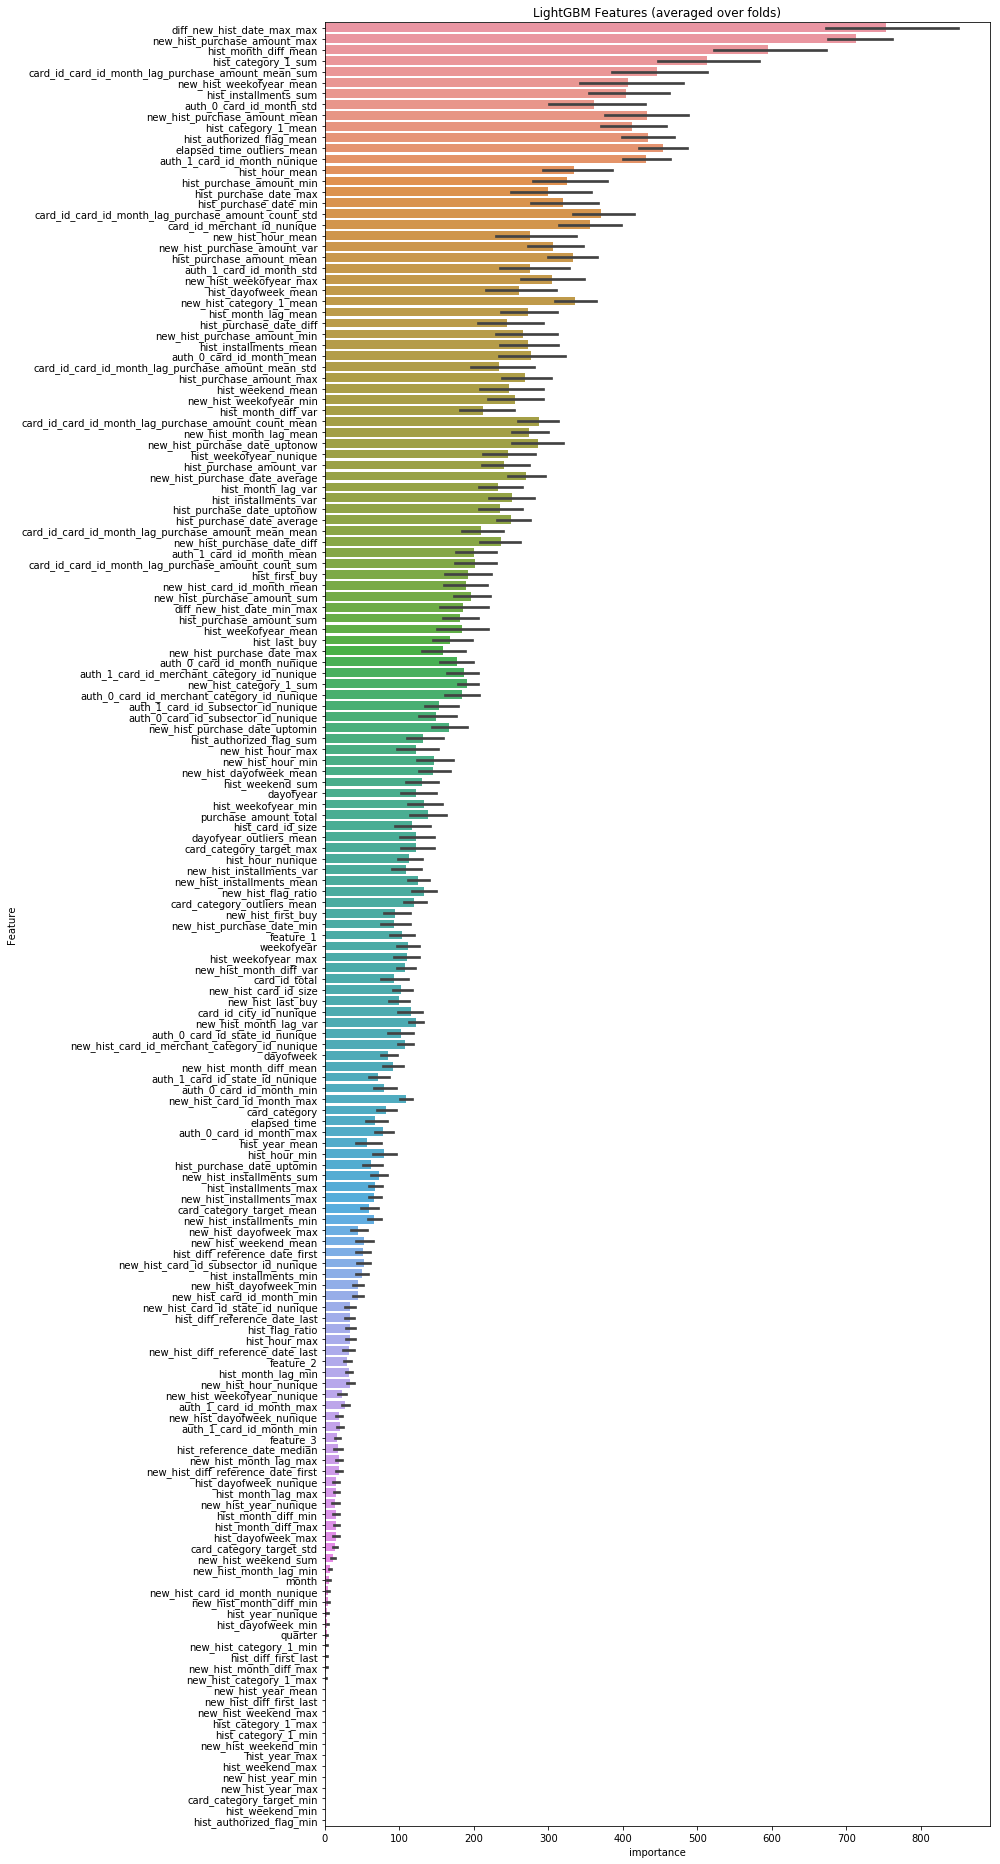

In [53]:
filename = '{}_cv{:.6f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), cv_score)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('fi/{}_lgbm_importances.png'.format(filename))

In [54]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df['target'] = predictions
#sub_df.loc[sub_df['target']<-9,'target'] = -33.21928095
sub_df.to_csv("output/combine_submission_{}.csv".format(filename), index=False)

# Post Processing

### without Outlier

In [52]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
train_df = train_df.loc[train_df['target']>-30]
"""
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_df = train_df.loc[train_df['target']>-30]
"""
train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [53]:
train = train_df.copy()
target = train['target']
del train['target']

In [55]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.5887	valid_1's rmse: 1.58104
[200]	training's rmse: 1.56208	valid_1's rmse: 1.5584
[300]	training's rmse: 1.54863	valid_1's rmse: 1.5502
[400]	training's rmse: 1.539	valid_1's rmse: 1.54599
[500]	training's rmse: 1.53112	valid_1's rmse: 1.5438
[600]	training's rmse: 1.52438	valid_1's rmse: 1.54278
[700]	training's rmse: 1.51833	valid_1's rmse: 1.54228
[800]	training's rmse: 1.5125	valid_1's rmse: 1.54174
[900]	training's rmse: 1.50701	valid_1's rmse: 1.54158
[1000]	training's rmse: 1.50179	valid_1's rmse: 1.54144
[1100]	training's rmse: 1.49655	valid_1's rmse: 1.5413
[1200]	training's rmse: 1.49167	valid_1's rmse: 1.54118
[1300]	training's rmse: 1.48688	valid_1's rmse: 1.54105
Early stopping, best iteration is:
[1288]	training's rmse: 1.48741	valid_1's rmse: 1.54102
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.58638	valid_1's rmse: 1.5979
[200

[700]	training's rmse: 1.5151	valid_1's rmse: 1.56614
[800]	training's rmse: 1.50947	valid_1's rmse: 1.56567
[900]	training's rmse: 1.50394	valid_1's rmse: 1.56527
[1000]	training's rmse: 1.49863	valid_1's rmse: 1.56488
[1100]	training's rmse: 1.49331	valid_1's rmse: 1.5646
[1200]	training's rmse: 1.48814	valid_1's rmse: 1.56429
[1300]	training's rmse: 1.48334	valid_1's rmse: 1.56421
[1400]	training's rmse: 1.47839	valid_1's rmse: 1.56405
[1500]	training's rmse: 1.4739	valid_1's rmse: 1.56393
[1600]	training's rmse: 1.46925	valid_1's rmse: 1.56379
[1700]	training's rmse: 1.46459	valid_1's rmse: 1.56363
[1800]	training's rmse: 1.46001	valid_1's rmse: 1.56355
Early stopping, best iteration is:
[1792]	training's rmse: 1.46033	valid_1's rmse: 1.5635
1.5545932017960689


In [56]:
model_without_outliers = pd.DataFrame({"card_id":test_df["card_id"].values})
model_without_outliers["target"] = withoutoutlier_predictions

### outlier

In [57]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
#train_df = train_df.loc[train_df['target']>-30]

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [58]:
train = train_df.copy()
target = train['outliers']
del train['target']
del train['outliers']

In [73]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 6}

folds = KFold(n_splits=9, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_+1))

    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target, oof)))

fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.150653	valid_1's binary_logloss: 0.152129
[200]	training's binary_logloss: 0.150649	valid_1's binary_logloss: 0.152129
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.150652	valid_1's binary_logloss: 0.152126
fold 2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.150844	valid_1's binary_logloss: 0.151017
[200]	training's binary_logloss: 0.150843	valid_1's binary_logloss: 0.151016
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.151197	valid_1's binary_logloss: 0.150898
fold 3
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.15086	valid_1's binary_logloss: 0.150476
[200]	training's binary_logloss: 0.150854	valid_1's binary_logloss: 0.150486
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.150854	valid_1's binary_logloss: 0.1504

In [74]:
df_outlier_prob = pd.DataFrame({"card_id":test_df["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.sort_values('target',ascending=False).head(25000)

,card_id,target
32446,C_ID_ac114ef831,0.443258
104991,C_ID_86ddafb51c,0.413310
43763,C_ID_74dd007aec,0.409457
44491,C_ID_75519a6d74,0.407247
83378,C_ID_8a93017bd2,0.405677
114106,C_ID_e54aeb08f7,0.392402
119851,C_ID_4cdcd7bbb1,0.385878
3398,C_ID_47a06004a5,0.384621
25739,C_ID_99db441486,0.383345
61765,C_ID_de36596567,0.381043


### Best Submission

In [86]:
outlier_id = pd.DataFrame(df_outlier_prob.sort_values('target',ascending=False).head(30000)['card_id'])

In [87]:
best_submission = pd.read_csv('output/combine_submission_20190122_163437_cv3.644946.csv')
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [88]:
only_without_outliers = model_without_outliers.loc[~model_without_outliers['card_id'].isin(most_likely_liers['card_id'].unique())]
submission = pd.concat([only_without_outliers, most_likely_liers])

In [89]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df = sub_df.merge(submission, on='card_id',how='left')
sub_df.loc[sub_df['card_id'].isin(df_outlier_prob.sort_values('target',ascending=False).head(20)['card_id'].values),'target'] = -33.21928095
sub_df.to_csv("output/combine_submission_postprocessing_{}_out0.15125.csv".format(cv_score), index=False)